# Introduction

This notebook looks at the auditory data in the DOD dataset, producing numerous PCA visualizations left for interpretation.

# PCA functions

In [35]:
# Required libraries
# !pip install mpl_axes_aligner openpyxl
# !pip install numpy pandas scikit-learn seaborn

In [36]:
# Loading the data
import pandas as pd
import numpy as np

def load_data(path): # = 'DOD_clinical_data.xlsx'
	xlsx = pd.ExcelFile(path)
	data = {}
	for sheetname in xlsx.sheet_names:
		sheet = pd.read_excel(xlsx, sheet_name=sheetname)
		data[sheetname] = sheet
	return data

In [37]:
# PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import mpl_axes_aligner

def principal_component_analysis(dataframe: pd.DataFrame, columns: list[str], n_components: int, label_path: str):

	"""
	Params:
	- dataframe: A dataframe containing all the samples (participants) as rows and the indexes being the ID.
	- columns: A list of strings that are the columns in dataframe. They must be valid columns in the dataframe.
	- n_components: Number of components to pass into PCA. If you don't know, just use the # of columns as your n_components.
	- label_ptah: Path to DOD_clinical_labels.xlsx
	"""

	print("\n --- START PCA ---\n")

	# Shaping our data for PCA
	data = dataframe[columns]
	for column in columns:
		data = data[pd.to_numeric(data[column], errors='coerce').notnull()] # Removes all non-numeric rows
	scaled_data = preprocessing.scale(data) # Centering makes the average 0. Scaling makes the standard deviation 1.

	# Input data into PCA
	pca = PCA(n_components=n_components)
	pca.fit(scaled_data) # Fit data
	pca_data = pca.transform(scaled_data) # Generate coordinates for graph

	# Look at the variance in each PC and plot
	per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
	labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

	# Save loadings
	loading_score = pd.DataFrame(pca.components_.T, columns=labels, index=columns)

	# Scree plot
	plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
	plt.ylabel('Percentage of Explained Variance')
	plt.xlabel('Principal Component')
	plt.title('Scree Plot')
	plt.show()

	# Label each data point in the 2 axes
	fig,ax = plt.subplots(figsize=(15,8))
	pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
	ax.scatter(pca_df.PC1, pca_df.PC2)
	ax.set_title('PCA Graph')
	ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
	ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
	for sample in pca_df.index:
		ax.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
	ax2 = ax.twinx().twiny() # Plot loadings on this same graph. Credit: https://insidelearningmachines.com/biplot/
	font = {'color':  'g',
		'weight': 'bold',
		'size': 12,
		}
	for col in loading_score.T.columns.values:
		tipx = loading_score.T.loc['PC1',col]
		tipy = loading_score.T.loc['PC2',col]
		ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
		ax2.text(tipx, tipy, col, fontdict = font, ha = 'center', va = 'center')
	mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
	mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
	plt.show()

	# Let's focus on the PC's that explain 90-95% of the data
	threshold = 0.95
	loading_tables = []
	total_variance = 0.0
	pc_index = 0
	while total_variance < threshold and pc_index < len(pca.explained_variance_ratio_):

		# Update variance tracker
		total_variance += pca.explained_variance_ratio_[pc_index]

		# Sort the respective PC based off of loadings
		sorted = loading_score.iloc[:, pc_index].copy()
		sorted = sorted.reindex(sorted.abs().sort_values(ascending=False).index)
		sorted = sorted.reset_index().rename(columns={'index': f'PCA{pc_index+1}_index'})

		# Save and move on to the next
		loading_tables.append(sorted)
		pc_index += 1

	# Combine into 1 giant dataframe
	all_loading_dfs = pd.concat(loading_tables, axis=1)
	print(f"\n {pc_index} PCs needed in order to explain {threshold*100}% variation\n")
	print(all_loading_dfs.to_string())

	# Append PCA information
	labels = pd.read_excel(label_path)
	pca_df['Clinical Profile'] = ['' for _ in range(len(pca_df))]
	pca_df['Military Profile'] = ['' for _ in range(len(pca_df))]
	for index, row in pca_df.iterrows():
		id_val = index
		clinical_match = labels.loc[labels['ID'] == id_val, 'Clinical Profile']
		military_match = labels.loc[labels['ID'] == id_val, 'Military Profile']
		if not clinical_match.empty:
			pca_df.at[index, 'Clinical Profile'] = clinical_match.iloc[0]
		if not military_match.empty:
			pca_df.at[index, 'Military Profile'] = military_match.iloc[0]

	print("\n --- END PCA ---\n")

	# Return data for K-Means clustering
	return scaled_data, pca_df


In [38]:
# K-means
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import contextlib
import io

# Inputting into K means
def k_means_clustering(k: int, scaled_data, pca_df, tuning=False):

	"""
	Params:
	- k: Number of clusters
	- scaled_data: Scaled data scaled after PCA function
	- pca_df: Dataframe after PCA function
	"""

	if not tuning:
		print(f"\n --- START K-MEANS {k} clusters ---\n")

	# Fit into KMeans object
	some_kmeans = KMeans(n_clusters=k).fit(scaled_data)

	# Input into pca_df
	name = f'{k} clusters'
	pca_df[name] = pd.Categorical(some_kmeans.labels_)

	# Plot colors of clusters
	if not tuning:
		sns.scatterplot(x="PC1",y="PC2",hue=name,data=pca_df)

	# Silhouette score
	fine_tune_kmeans = KMeans(n_clusters=k)
	score = silhouette_score(scaled_data, fine_tune_kmeans.fit_predict(scaled_data)) # We're looking for a score above 70%
	if not tuning:
		print(f"Silhouette score: {score}")
	if not tuning:
		print(f"\n --- END K-MEANS {k} clusters ---\n")

	# Output new pca_df with score
	return pca_df, score

# Tuning for best K-means
def k_means_tuning(k_range, scaled_data, pca_df):

	"""
	Params:
	- k_range: For our use case, probably just range(2, 8). Lower bound must be 2 or else clustering is kind of useless
	- scaled_data: Same as before
	- pca_df: Same as before
	"""

	print(f"\n --- START K-MEANS TUNING ---\n")

	# Iterate through all K in that range
	results = []
	for k in k_range:
		_, score = k_means_clustering(k, scaled_data.copy(), pca_df.copy(), tuning=True)
		results.append((k,score))

	# Find the highest score
	scores_df = pd.DataFrame(results, columns=['k', 'silhouette_score'])
	best_idx = scores_df['silhouette_score'].idxmax()
	best_k = scores_df.loc[best_idx, 'k']
	best_score = scores_df.loc[best_idx, 'silhouette_score']
	print(f"Best k: {best_k}")
	print(f"Best score: {best_score}")
	print(f"\n --- END K-MEANS TUNING ---\n")

	# Output best scores
	return best_k, best_score


In [39]:
# Show the PCA graph with the colors of the clinical & military profiles
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def graph_classification(pca_df):

    """
    Params:
    - pca_df: must have "Clinical Profile" and "Military Profile" columns
    """

    # Plot Clinical Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Clinical Profile", data=pca_df)
    plt.title("PCA - Clinical Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Military Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Military Profile", data=pca_df)
    plt.title("PCA - Military Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [40]:
# Grab the average between a left and right column. Unlike .mean(), this handles NA values.
def average_columns(left_column, right_column):

	"""
	Example usage:
	test_df['PTA_A'] = average_columns(test_df['PTA_A_L'], test_df['PTA_A_R'])
	"""

	averages = []
	for left, right in zip(left_column.values, right_column.values):
		average = 0
		if left == None and right == None:
			average = None
		elif left == None:
			average = right
		elif right == None:
			average = left
		else:
			average = (float(left) + float(right))/2
		averages.append(average)
	return averages


# Finding salient variables with PCA.

PCA review:
- PC's are ranked by the amount of variability they capture.
- PC's are a linear combination of the variables in your dataset.
	- The coefficients of the linear combinations are called "loadings"

Loading notes:
- The sign tells you whether the INCLUSION (+) or ABSENSE (-) of it contributes to the PC.
- The mangitude tells you how much the inclusion/absense of it contributes (higher = more contribution).

For now, we can look at which variables are informative or redundant. Here are some notes:
- Variables that contribute heavily to the same PC are likely redundant (PCA combines them into the same signal)
- Variables that contribute across many components are important and complex
- Variables with low contributions across many components are probably uninformative

Furthermore, loading plots will tell us information about variables
- Variables grouped together will be positively correlated (tendency to change the same way, but is it safe to call this redundant?)
- Variables opposite to each other w/ respect to the origin are negatively correlated 
- Variables farther to the origin are "stronger" / more influential.

PCA summarizes: Trends, jumps, clusters, and outliers

# Visualizing data with PCA

In [41]:
# Change these paths to match your working directory.
label_path = '../data/DOD_clinical_labels_from_excel.xlsx'
data_path = '../data/DOD_clinical_data.xlsx'

Final AirCon data length: 203
Final BoneCon data length: 203
Final Speech data length: 203
Final Tymp data length: 202
Final Summary data length: 185
Total data length after NA removal: 105

 --- START PCA ---



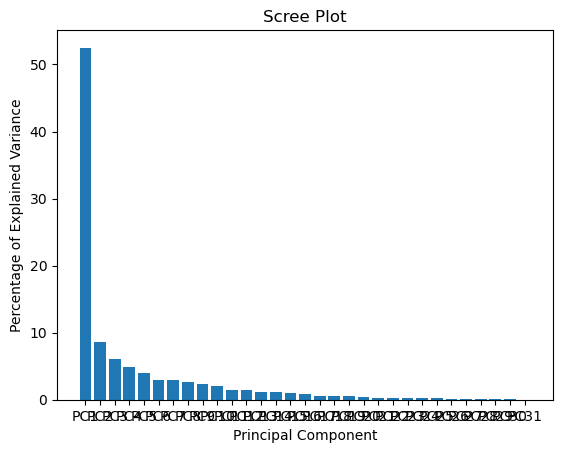

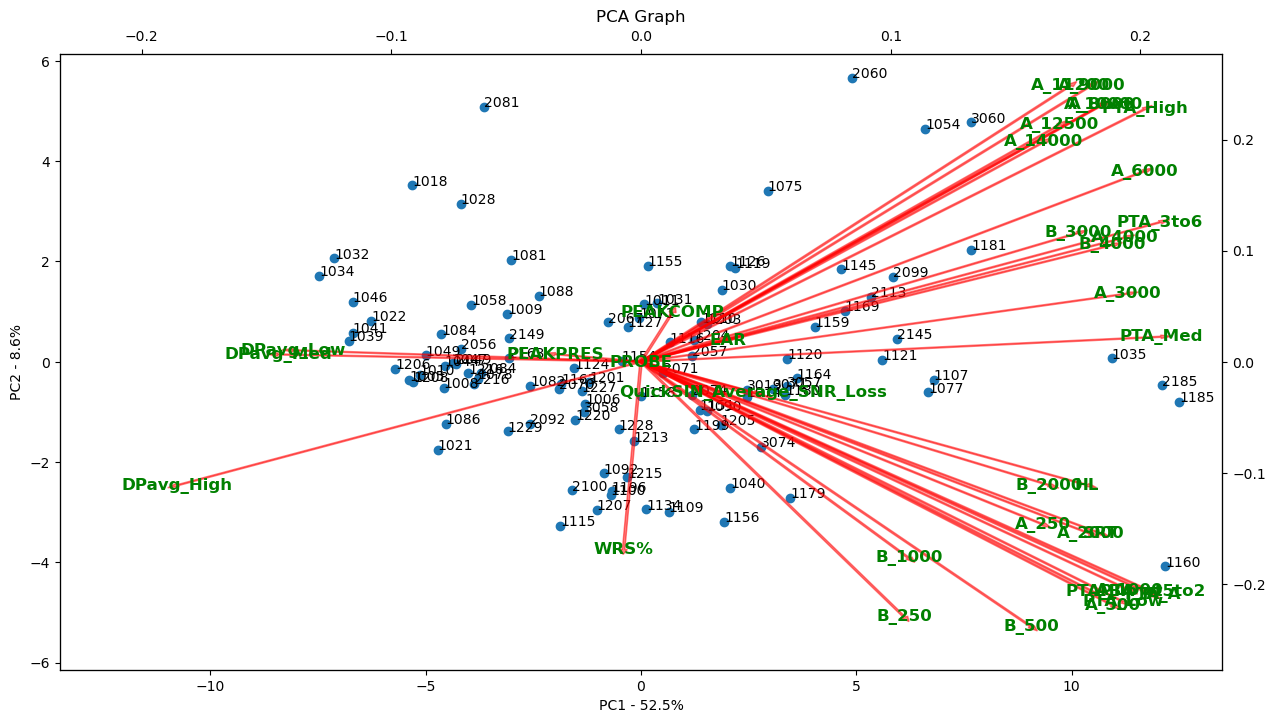


 15 PCs needed in order to explain 95.0% variation

                   PCA1_index       PC1                 PCA2_index           PC2                 PCA3_index           PC3                 PCA4_index       PC4                 PCA5_index           PC5                 PCA6_index       PC6                 PCA7_index       PC7                 PCA8_index           PC8                 PCA9_index           PC9                PCA10_index          PC10                PCA11_index          PC11                PCA12_index          PC12                PCA13_index          PC13                PCA14_index      PC14                PCA15_index          PC15
0                     PTA_Med  0.208172                     A_9000  2.488360e-01                   PEAKCOMP  3.967125e-01                   PEAKPRES  0.374581                        EAR  5.784775e-01  QuickSIN_Average_SNR_Loss  0.482205                       WRS%  0.504703  QuickSIN_Average_SNR_Loss  3.535691e-01                      B_250  5.9526

In [46]:
# Grab data and combine
data = load_data(data_path)
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirConHigh']['ID'])
bonecon_df= data['BoneCon'].set_index(data['BoneCon']['ID'])
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
speech_df = data['Speech'].set_index(data['Speech']['ID'])
tymp_df = data['Tymp'].set_index(data['Tymp']['ID'])
summary_df = data['Summary'].set_index(data['Summary']['ID'])

# Organize AirCon Data
# Note: If we removed all participants that had a DNC or NR reading, we will have 19 participants left.
# Therefore, a better solution is to exclude the higher frequencies which have a whole lot more of those values.
aircon_high_df.drop(columns=['RU8000', 'LU8000'], inplace=True) # Redundant info
aircon_all_df = pd.concat([aircon_low_df, aircon_high_df], axis = 1)
aircon_all_df_cleaned = aircon_all_df.replace({"DNC" : None, "NR" : None})
aircon_all_df_cleaned.drop(columns=['RU16000', 'RU18000', 'RU20000', 'LU16000', 'LU18000', 'LU20000'], inplace=True)
# Average between left and right
aircon_all_df_averaged = aircon_all_df_cleaned.copy()
for column in aircon_all_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_df_averaged["A_"+frequency] = average_columns(aircon_all_df_averaged[column], aircon_all_df_averaged['LU'+str(frequency)])
aircon_all_df_averaged['PTA_A'] = average_columns(aircon_all_df_averaged['PTA_A_R'], aircon_all_df_averaged['PTA_A_L'])
# Drop the original columns, leaving just the averages
aircon_all_df_final = aircon_all_df_averaged.drop(columns=[*aircon_all_df_cleaned.columns])
print(f"Final AirCon data length: {len(aircon_all_df_final)}")

# Organize BoneCon data
bonecon_df_cleaned = bonecon_df.replace({"DNC" : None, "NR" : None})
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_df_cleaned = bonecon_df_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
bonecon_df_cleaned.drop(columns=['RU8000', 'LU8000', 'RU6000', 'LU6000'], inplace=True) # Also drop these because they're NA for mostly everyone.
# Average between left and right
bonecon_df_averaged = bonecon_df_cleaned.copy()
for column in bonecon_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_df_averaged["B_"+frequency] = average_columns(bonecon_df_averaged[column], bonecon_df_averaged['LU'+str(frequency)])
bonecon_df_averaged['PTA_B'] = average_columns(bonecon_df_averaged['PTA_B_R'], bonecon_df_averaged['PTA_B_L'])
# Drop the original columns, leaving just the averages
bonecon_df_final = bonecon_df_averaged.drop(columns=[*bonecon_df_cleaned.columns])
print(f"Final BoneCon data length: {len(bonecon_df_final)}")

# Organize Speech data
speech_df_cleaned = speech_df.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'])
# Average between left and right. Note: R_WRS_MASK might have a space in the column name.
speech_df_averaged = speech_df_cleaned.copy()
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged:
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])
# Drop the original columns, leaving just the averages
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep)))
print(f"Final Speech data length: {len(speech_df_final)}")

# Organize Tymp data
tymp_df_cleaned = tymp_df.drop(columns=['ID', 'Tymp_Date'])
# Average between left and right
tymp_df_averaged = tymp_df_cleaned.copy()
for column in tymp_df_averaged:
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_df_averaged[name] = average_columns(tymp_df_averaged[column], tymp_df_averaged['TL_'+str(name)])
# Drop the original columns, leaving just the averages
tymp_df_final = tymp_df_averaged.drop(columns=list(set([*tymp_df_cleaned.columns]) - set(keep)))
print(f"Final Tymp data length: {len(tymp_df_final)}")

# Organize Summary data
summary_df_columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']
summary_df_final = summary_df[summary_df_columns]
print(f"Final Summary data length: {len(summary_df_final)}")

# Combine all dataframes
all_df = pd.concat([aircon_all_df_final, bonecon_df_final, speech_df_final, tymp_df_final, summary_df_final], axis = 1)

# Remove certain columns that have a lot of NA values
drop_columns = ["WRS_MASK", "PTA_12pt5to16"] # Some columns that have a lot of NA values
all_df.drop(columns=drop_columns, inplace=True)
print(f"Total data length after NA removal: {len(all_df.dropna())}")

# Run PCA functions
scaled_data, pca_df = principal_component_analysis(dataframe=all_df,
												   columns=all_df.columns,
												   n_components=31, # Arbitary max
													 label_path=label_path)
# Optional: Run K-means functions
# new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
# best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
# graph_classification(pca_df)

These are variables that Brett deems as informative:
- Summary & AirCon: PTA LOW PTA MED PTA HIGH & DP AVG LOW DP AVG MED DP AVG HIGH
- Speech: SRT_RIGHT SRT_LEFT (AVGED), QUICKSIN AVG
- Tymp: Peak compliance and Peak pressure

Final AirCon data length: 203
Final BoneCon data length: 203
Final Speech data length: 203
Final Tymp data length: 202
Final Summary data length: 185
Total data length after NA removal: 169

 --- START PCA ---



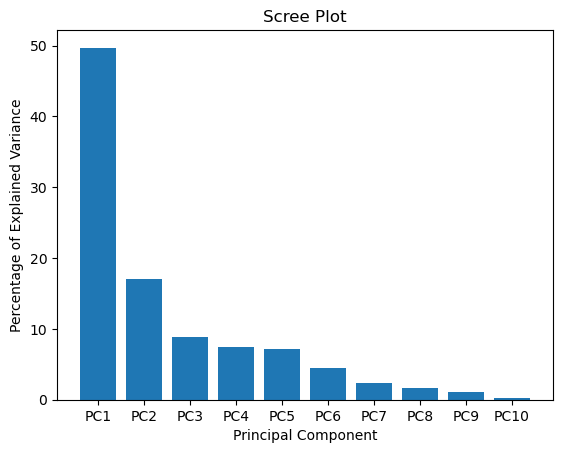

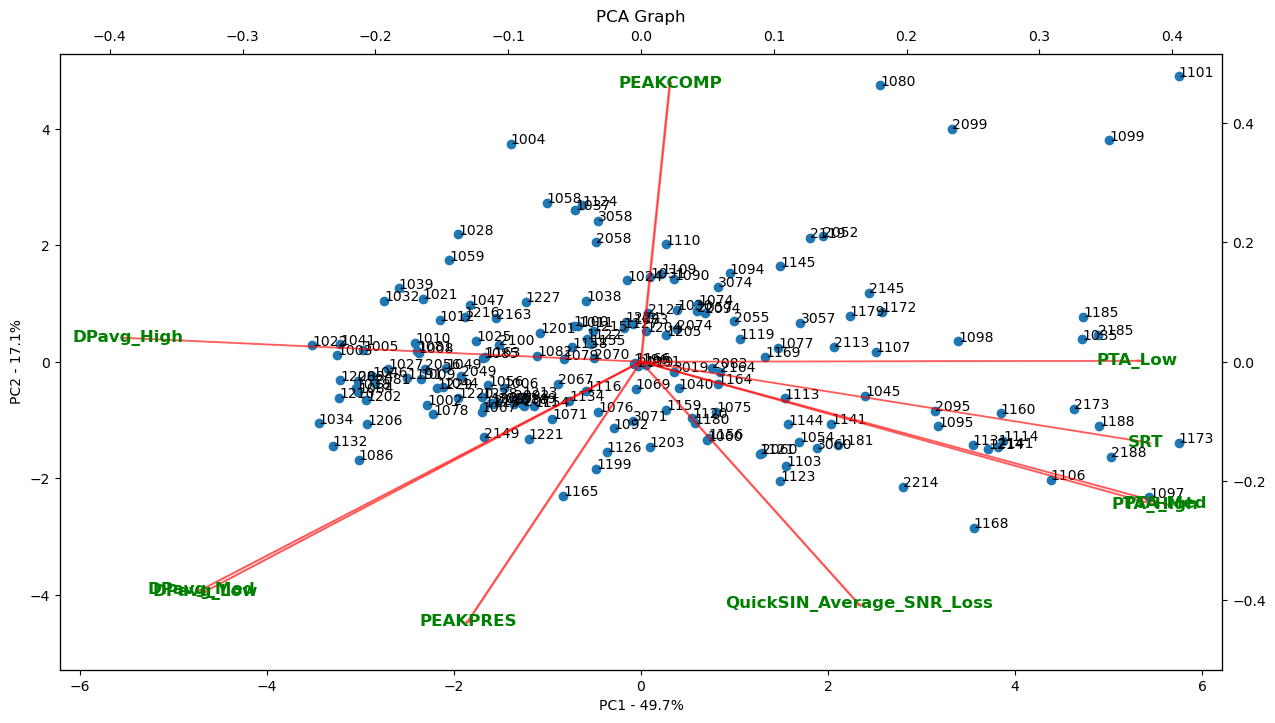


 7 PCs needed in order to explain 95.0% variation

                  PCA1_index       PC1                 PCA2_index       PC2                 PCA3_index       PC3                 PCA4_index       PC4                 PCA5_index       PC5                 PCA6_index       PC6                 PCA7_index       PC7
0                    PTA_Med  0.394369                   PEAKCOMP  0.466424                   PEAKCOMP  0.635353                   PEAKPRES  0.601667  QuickSIN_Average_SNR_Loss  0.587085                    PTA_Low  0.690496                        SRT  0.774495
1                   PTA_High  0.386882                   PEAKPRES -0.435035                  DPavg_Low  0.408175  QuickSIN_Average_SNR_Loss -0.587611                   PEAKPRES  0.486974                 DPavg_High  0.519105                    PTA_Low -0.408348
2                 DPavg_High -0.386487  QuickSIN_Average_SNR_Loss -0.406373                   PEAKPRES -0.408087                   PEAKCOMP  0.421127                

In [44]:
# Grab data and combine
data = load_data(data_path)
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirConHigh']['ID'])
bonecon_df= data['BoneCon'].set_index(data['BoneCon']['ID'])
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
speech_df = data['Speech'].set_index(data['Speech']['ID'])
tymp_df = data['Tymp'].set_index(data['Tymp']['ID'])
summary_df = data['Summary'].set_index(data['Summary']['ID'])

# Organize AirCon Data
# Note: If we removed all participants that had a DNC or NR reading, we will have 19 participants left.
# Therefore, a better solution is to exclude the higher frequencies which have a whole lot more of those values.
aircon_high_df.drop(columns=['RU8000', 'LU8000'], inplace=True) # Redundant info
aircon_all_df = pd.concat([aircon_low_df, aircon_high_df], axis = 1)
aircon_all_df_cleaned = aircon_all_df.replace({"DNC" : None, "NR" : None})
aircon_all_df_cleaned.drop(columns=['RU16000', 'RU18000', 'RU20000', 'LU16000', 'LU18000', 'LU20000'], inplace=True)
# Average between left and right
aircon_all_df_averaged = aircon_all_df_cleaned.copy()
for column in aircon_all_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_df_averaged["A_"+frequency] = average_columns(aircon_all_df_averaged[column], aircon_all_df_averaged['LU'+str(frequency)])
aircon_all_df_averaged['PTA_A'] = average_columns(aircon_all_df_averaged['PTA_A_R'], aircon_all_df_averaged['PTA_A_L'])
# Drop the original columns, leaving just the averages
aircon_all_df_final = aircon_all_df_averaged.drop(columns=[*aircon_all_df_cleaned.columns])
print(f"Final AirCon data length: {len(aircon_all_df_final)}")

# Organize BoneCon data
bonecon_df_cleaned = bonecon_df.replace({"DNC" : None, "NR" : None})
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_df_cleaned = bonecon_df_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
bonecon_df_cleaned.drop(columns=['RU8000', 'LU8000', 'RU6000', 'LU6000'], inplace=True) # Also drop these because they're NA for mostly everyone.
# Average between left and right
bonecon_df_averaged = bonecon_df_cleaned.copy()
for column in bonecon_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_df_averaged["B_"+frequency] = average_columns(bonecon_df_averaged[column], bonecon_df_averaged['LU'+str(frequency)])
bonecon_df_averaged['PTA_B'] = average_columns(bonecon_df_averaged['PTA_B_R'], bonecon_df_averaged['PTA_B_L'])
# Drop the original columns, leaving just the averages
bonecon_df_final = bonecon_df_averaged.drop(columns=[*bonecon_df_cleaned.columns])
print(f"Final BoneCon data length: {len(bonecon_df_final)}")

# Organize Speech data
speech_df_cleaned = speech_df.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'])
# Average between left and right. Note: R_WRS_MASK might have a space in the column name.
speech_df_averaged = speech_df_cleaned.copy()
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged:
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])
# Drop the original columns, leaving just the averages
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep)))
print(f"Final Speech data length: {len(speech_df_final)}")

# Organize Tymp data
tymp_df_cleaned = tymp_df.drop(columns=['ID', 'Tymp_Date'])
# Average between left and right
tymp_df_averaged = tymp_df_cleaned.copy()
for column in tymp_df_averaged:
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_df_averaged[name] = average_columns(tymp_df_averaged[column], tymp_df_averaged['TL_'+str(name)])
# Drop the original columns, leaving just the averages
tymp_df_final = tymp_df_averaged.drop(columns=list(set([*tymp_df_cleaned.columns]) - set(keep)))
print(f"Final Tymp data length: {len(tymp_df_final)}")

# Organize Summary data
summary_df_columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']
summary_df_final = summary_df[summary_df_columns]
print(f"Final Summary data length: {len(summary_df_final)}")

# Combine all dataframes
all_df = pd.concat([aircon_all_df_final, bonecon_df_final, speech_df_final, tymp_df_final, summary_df_final], axis = 1)

# Brett's columns
BrettColumns = ['PTA_Low', 'PTA_Med', 'PTA_High', 'DPavg_Low', 'DPavg_Med', 'DPavg_High', 'SRT', 'QuickSIN_Average_SNR_Loss', 'PEAKCOMP', 'PEAKPRES']
all_df = all_df[BrettColumns]
print(f"Total data length after NA removal: {len(all_df.dropna())}")

# Run PCA functions
scaled_data, pca_df = principal_component_analysis(dataframe=all_df,
												   columns=all_df.columns,
												   n_components=len(BrettColumns),
													 label_path=label_path)
# Optional: Run K-means functions
# new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
# best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
# graph_classification(pca_df)